In [1]:
# import os
import sys
import gc

# прописываем нужный нам путь к проекту
from pathlib import Path
PATH = Path('../..') # proj_news_viz/nlp
sys.path.append(str(PATH))

import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# import matplotlib.pyplot as plt
# plt.style.use('dark_background')
%matplotlib inline

---
возьмем для примера датасет [lenta.ru](https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta)

для примера взят датасет, скаченный по линку с [gitHub](https://github.com/yutkin/Lenta.Ru-News-Dataset/tree/v1.1)

In [3]:
!pwd

/home/avenon/projects/proj_news_viz/nlp/references/techarticle


In [4]:
df = pd.read_csv(PATH / 'data/interim/lenta/lenta-ru-news.csv')
print(df.shape)
df.sample(2)

(739351, 5)


,url,title,text,topic,tags
259504,https://lenta.ru/news/2013/09/13/gosha/,В Смоленске изловили лебедя-беглеца Гошу,В Смоленске проведена операция по поимке лебед...,Из жизни,Звери
471099,https://lenta.ru/news/2009/02/09/temple/,"Даосский храм заработал ростовщичеством на ""пя...",Даосский храм Тзенань на юго-востоке Тайваня о...,Из жизни,Все


удалим пустые записи и дубликаты по признаку `text`

In [5]:
df.dropna(inplace=True)
df.text.drop_duplicates(inplace=True)

print(f'df.shape: {df.shape}')
df.isnull().sum()

df.shape: (712829, 5)


url      0
title    0
text     0
topic    0
tags     0
dtype: int64

In [6]:
# посмотрим на к-ство записей по разделам
print(f'уникальное к-ство разделов: {df.topic.unique().shape[0]}')
df.topic.value_counts()

уникальное к-ство разделов: 23


Россия               155078
Мир                  136679
Экономика             76433
Спорт                 57902
Культура              53536
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44433
Из жизни              27519
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

In [7]:
# выберем для примера топ-5 разделов
top_topics = 5
df_top = df[df.topic.isin(df.topic.value_counts().head(top_topics).index)]
df_top.shape

(479628, 5)

In [8]:
df_top.head()

,url,title,text,topic,tags
0,https://lenta.ru/news/2018/12/14/cancer/,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Общество
1,https://lenta.ru/news/2018/12/15/doping/,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Зимние виды
3,https://lenta.ru/news/2018/12/15/usa25/,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,Политика
4,https://lenta.ru/news/2018/12/15/integrity/,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Общество
7,https://lenta.ru/news/2018/12/15/skripal/,Полицейские из Солсбери описали одеревеневшего...,"Полицейские Алекс Коллинс и Трейси Холлоуэй, о...",Мир,Общество


---
разделим данные для начала на train & test в соотношении 80/20 соответственно

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_top.text,df_top.topic,
                                                    test_size=0.2,
                                                    stratify=df_top.topic,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((383702,), (95926,), (383702,), (95926,))

In [11]:
# проверим на пустые значения
X_train.isna().sum(), X_test.isna().sum()

(0, 0)

In [12]:
y_test

28457          Мир
731343      Россия
387135       Спорт
22328        Спорт
614875      Россия
            ...   
253051         Мир
546115      Россия
727936      Россия
510561      Россия
516661    Культура
Name: topic, Length: 95926, dtype: object

---
## сделаем небольшое исследование, обучив модель с и без препроцессинга

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
# добавим самописный файл, для отображения топ частотный слов
from news_viz.visualization.plot_frequency import plotFrequencyWords

* ### без препроцессинга

### Метод векторизации: Частотный

In [32]:
%%time
count_vect = CountVectorizer()

# в данном примере обучим только на `X_train`
# но ничего не мешает обучить и на `X_test`
count_vect_train = count_vect.fit_transform(X_train)
count_vect_test = count_vect.transform(X_test)

CPU times: user 1min 40s, sys: 1.19 s, total: 1min 41s
Wall time: 1min 41s


In [33]:
# распределение токенов
vocab = {a: b for a, b in zip(count_vect.get_feature_names(), np.ravel(count_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер корпуса: {len(vocab)}')
print(f'\nпример [:5]: {vocab[:5]}')

размер корпуса: 732908

пример [:5]: [('на', 1330966), ('по', 810857), ('что', 771161), ('не', 540556), ('из', 405050)]


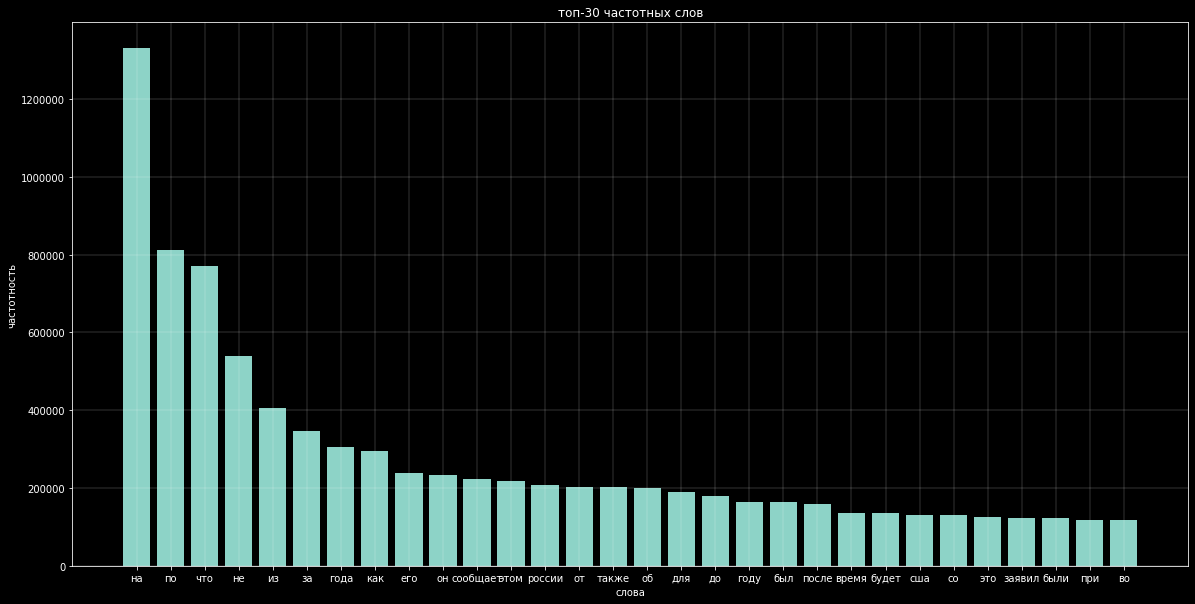

In [34]:
plotFrequencyWords(vocab = vocab,
                   top_words = 30,
                   plt_background = 'dark')

In [35]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_train, y_train)

pred_lr = lr.predict(count_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.94119   0.94910   0.94513     10707
         Мир    0.88884   0.89885   0.89382     27336
      Россия    0.89967   0.88242   0.89096     31016
       Спорт    0.98140   0.97988   0.98064     11580
   Экономика    0.91233   0.92517   0.91870     15287

    accuracy                        0.91312     95926
   macro avg    0.92469   0.92708   0.92585     95926
weighted avg    0.91310   0.91312   0.91307     95926

confusion_matrix:
[[10162   256   232    13    44]
 [  278 24571  1998    70   419]
 [  301  2372 27369   106   868]
 [   27    68   110 11347    28]
 [   29   377   712    26 14143]]
CPU times: user 8min 11s, sys: 17.6 s, total: 8min 29s
Wall time: 5min


In [ ]:
# from sklearn.pipeline import Pipeline
# 
# pipe = Pipeline([('vec', CountVectorizer(min_df=0.1)),
#                 ('clf', LogisticRegression(class_weight='balanced', random_state=42))])
# 
# pipe.fit(X_train,y_train)
# 
# pred_lr = pipe.predict(X_test)
# print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
# print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

### Метод векторизации: TF-IDF

In [37]:
%%time
count_vect_tfidf = TfidfVectorizer()

# в данном примере обучим только на `X_train`
# но ничего не мешает обучить и на `X_test`
count_vect_tfidf_train = count_vect_tfidf.fit_transform(X_train)
count_vect_tfidf_test = count_vect_tfidf.transform(X_test)

CPU times: user 1min 45s, sys: 1.5 s, total: 1min 47s
Wall time: 1min 47s


In [39]:
# распределение токенов
vocab_tfidf = {a: b for a, b in zip(count_vect_tfidf.get_feature_names(), np.ravel(count_vect_tfidf_train.sum(axis=0)))}
vocab_tfidf = sorted(vocab_tfidf.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер корпуса: {len(vocab_tfidf)}')
print(f'\nпример [:5]: {vocab_tfidf[:5]}')

размер корпуса: 732908

пример [:5]: [('на', 15876.362137721202), ('по', 10785.701971504219), ('что', 10644.883353085264), ('не', 8277.535585702457), ('из', 6927.856234873247)]


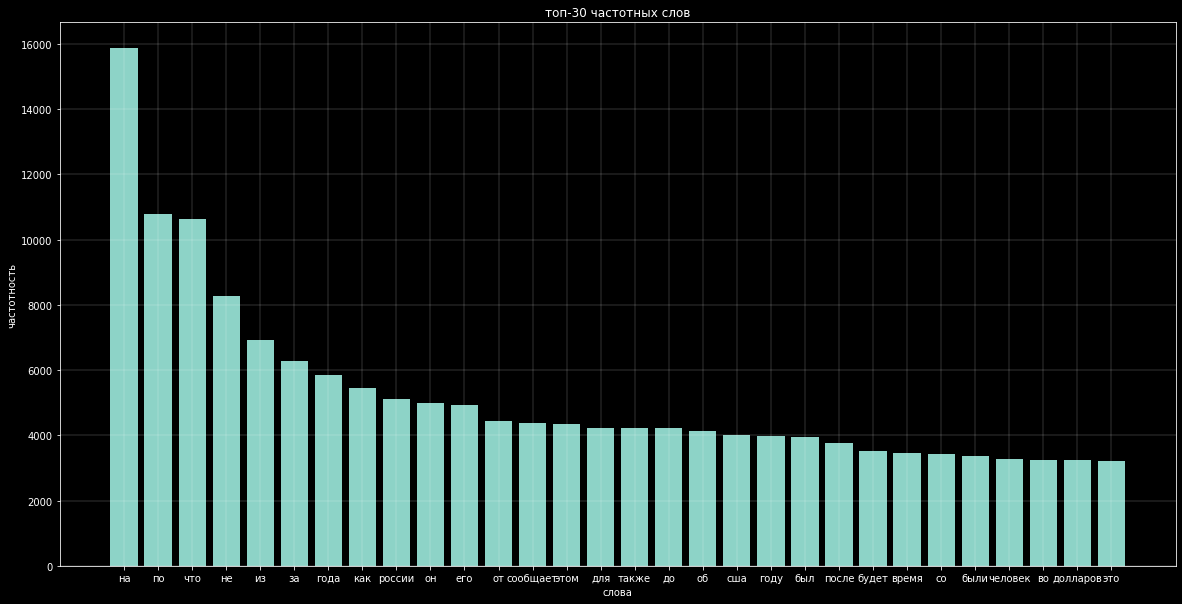

In [40]:
plotFrequencyWords(vocab = vocab_tfidf,
                   top_words = 30,
                   plt_background = 'dark')

In [41]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_tfidf_train, y_train)

pred_lr = lr.predict(count_vect_tfidf_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.92616   0.96647   0.94589     10707
         Мир    0.89627   0.90558   0.90090     27336
      Россия    0.91718   0.87726   0.89677     31016
       Спорт    0.98000   0.98152   0.98076     11580
   Экономика    0.90743   0.94198   0.92438     15287

    accuracy                        0.91819     95926
   macro avg    0.92541   0.93456   0.92974     95926
weighted avg    0.91825   0.91819   0.91797     95926

confusion_matrix:
[[10348   150   163    14    32]
 [  369 24755  1708    66   438]
 [  373  2335 27209   124   975]
 [   37    62    91 11366    24]
 [   46   318   495    28 14400]]
CPU times: user 7min 30s, sys: 16.4 s, total: 7min 46s
Wall time: 4min 22s


* ### c препроцессингом

In [15]:
from news_viz.data.preprocessing_tools import clean_text, lemmatize
# pip install pymorphy2

In [16]:
# импортируем нужные нам библиотеки для мультипроцессинга
# создаем соответствующую для этого функцию
import multiprocessing as mp
from multiprocessing import Pool

num_cores = mp.cpu_count() # number of cores on your machine; 20
num_partitions = num_cores * 2 # number of partitions to split dataframe

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [17]:
train = pd.DataFrame(X_train)
train['target'] = pd.DataFrame(y_train)

test = pd.DataFrame(X_test)
test['target'] = pd.DataFrame(y_test)

* оставим только слова

In [18]:
def multiply_clean_text(data):
    data['clean_text'] = data['text'].apply(clean_text)
    return data

In [19]:
%%time

print('clean train text & drop missing rows ...')
train = parallelize_dataframe(train, multiply_clean_text)
train = train[train.clean_text != 'TOREMOVE']

print('clean test text & drop missing rows ...')
test = parallelize_dataframe(test, multiply_clean_text)
test = test[test.clean_text != 'TOREMOVE']

gc.collect()

clean train text & drop missing rows ...
clean test text & drop missing rows ...
CPU times: user 12.5 s, sys: 8.31 s, total: 20.8 s
Wall time: 44 s


0

* лемматизируем и удалим заодно стоп-слова

In [20]:
def multiply_lemmatization(data):
    data['lemma_text'] = data['clean_text'].apply(lemmatize)
    return data

In [21]:
%%time

print('lemmatization train ...')
train = parallelize_dataframe(train, multiply_lemmatization)
train = train[train.lemma_text != 'TOREMOVE']

gc.collect()

print('lemmatization test ...')
test = parallelize_dataframe(test, multiply_lemmatization)
test = test[test.lemma_text != 'TOREMOVE']

gc.collect()

lemmatization train ...
lemmatization test ...
CPU times: user 22.7 s, sys: 16.4 s, total: 39 s
Wall time: 48min 4s


0

In [22]:
print(train.lemma_text.isnull().sum() , test.lemma_text.isnull().sum())

print(train.shape, test.shape)

train.sample(2)

0 0
(382995, 4) (95721, 4)


,text,target,clean_text,lemma_text
39983,Президент России Владимир Путин принял участие...,Россия,президент россии владимир путин принял участие...,россия владимир путин принять участие крещенск...
54750,Канадского сценариста и наследника крупной ком...,Мир,канадского сценариста наследника крупной компа...,канадский сценарист наследник крупный компания...


---
_на случай, если не хватает памяти_

In [23]:
train[['lemma_text','target']].to_csv(PATH / 'data/another/processed/lenta/news_lenta-lemma_text-train.csv.gz', compression='gzip', index=False)
test[['lemma_text','target']].to_csv(PATH / 'data/another/processed/lenta/news_lenta-lemma_text-test.csv.gz', compression='gzip', index=False)
# del train, test

In [ ]:
train = pd.read_csv(PATH / 'data/another/processed/lenta/news_lenta-lemma_text-train.csv.gz', compression='gzip')
test = pd.read_csv(PATH / 'data/another/processed/lenta/news_lenta-lemma_text-test.csv.gz', compression='gzip')

In [24]:
print(train.shape, test.shape)
train.sample(2)

(382995, 4) (95721, 4)


,text,target,clean_text,lemma_text
606798,США увеличили численность своего военного конт...,Мир,сша увеличили численность своего военного конт...,сша увеличить численность военный контингент и...
443355,"Сообщение о теракте, из-за которого 21 августа...",Россия,сообщение теракте из-за которого августа были ...,сообщение теракт из-за август эвакуировать пац...


---
* обучаем модель на очищенных данных

In [25]:
X_train = train.lemma_text
y_train = train.target

X_test  = test.lemma_text
y_test = test.target

### Метод векторизации: Частотный

In [26]:
%%time
count_vect = CountVectorizer()

count_vect_train = count_vect.fit_transform(X_train)
count_vect_test = count_vect.transform(X_test)

CPU times: user 1min 3s, sys: 969 ms, total: 1min 4s
Wall time: 1min 4s


In [27]:
# распределение токенов
vocab = {a: b for a, b in zip(count_vect.get_feature_names(), np.ravel(count_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер словаря: {len(vocab)}')
print(f'\nпример [:5]: {vocab[:5]}')

размер словаря: 283578

пример [:5]: [('сообщать', 235557), ('россия', 231117), ('заявить', 170430), ('российский', 150305), ('страна', 146518)]


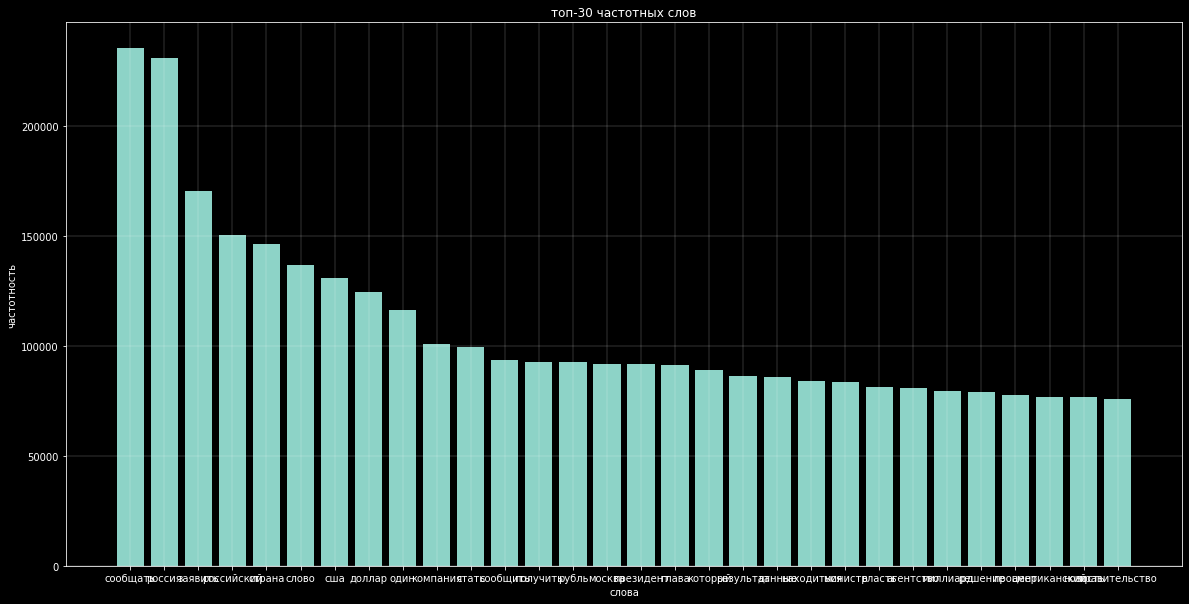

In [29]:
plotFrequencyWords(vocab = vocab,
                   top_words = 30,
                   plt_background = 'dark')

In [30]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_train, y_train)

pred_lr = lr.predict(count_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.93674   0.94637   0.94153     10703
         Мир    0.88482   0.89121   0.88800     27246
      Россия    0.89510   0.87750   0.88621     30922
       Спорт    0.98087   0.97875   0.97981     11579
   Экономика    0.90338   0.92266   0.91292     15271

    accuracy                        0.90856     95721
   macro avg    0.92018   0.92330   0.92170     95721
weighted avg    0.90852   0.90856   0.90849     95721

confusion_matrix:
[[10129   276   229    15    54]
 [  307 24282  2103    68   486]
 [  318  2410 27134   115   945]
 [   24    77   123 11333    22]
 [   35   398   725    23 14090]]
CPU times: user 5min 19s, sys: 13.5 s, total: 5min 32s
Wall time: 2min 31s


### Метод векторизации: TF-IDF

In [33]:
%%time
count_vect_tfidf = TfidfVectorizer()

count_vect_tfidf_train = count_vect_tfidf.fit_transform(X_train)
count_vect_tfidf_test = count_vect_tfidf.transform(X_test)

CPU times: user 1min 9s, sys: 922 ms, total: 1min 10s
Wall time: 1min 10s


In [34]:
# распределение токенов
vocab_tfidf = {a: b for a, b in zip(count_vect_tfidf.get_feature_names(), np.ravel(count_vect_tfidf_train.sum(axis=0)))}
vocab_tfidf = sorted(vocab_tfidf.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер словаря: {len(vocab_tfidf)}')
print(f'\nпример [:5]: {vocab_tfidf[:5]}')

размер словаря: 283578

пример [:5]: [('россия', 6339.544585950091), ('сообщать', 5206.5126845346485), ('доллар', 4772.206863452099), ('сша', 4700.352449168429), ('российский', 4665.17917406637)]


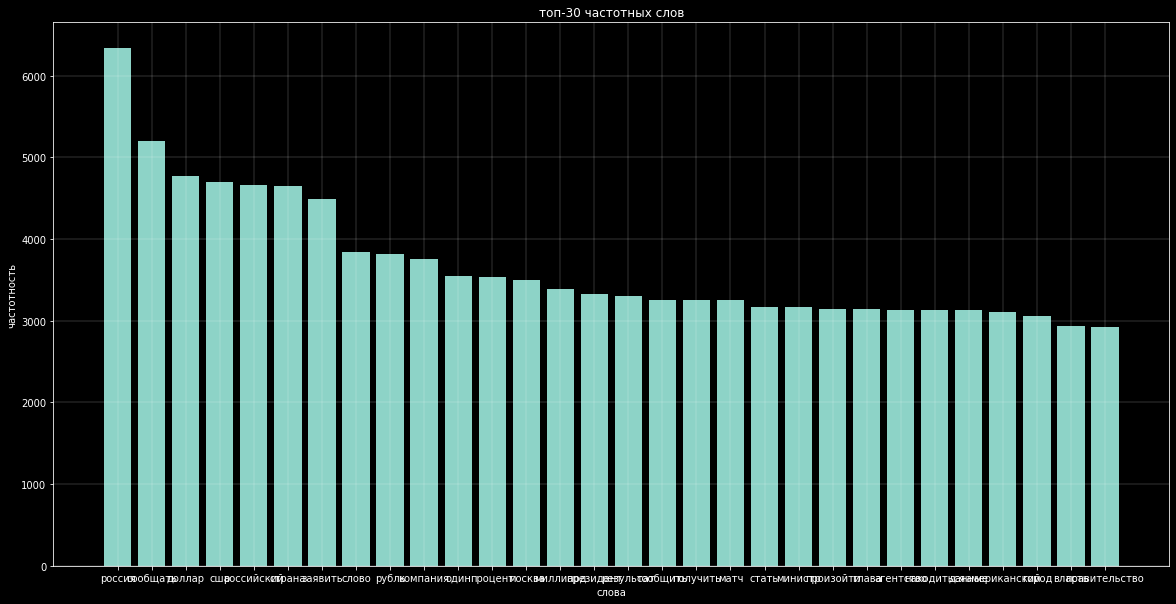

In [35]:
plotFrequencyWords(vocab = vocab_tfidf,
                   top_words = 30,
                   plt_background = 'dark')

In [36]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_tfidf_train, y_train)

pred_lr = lr.predict(count_vect_tfidf_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.92683   0.97169   0.94873     10703
         Мир    0.89633   0.90149   0.89890     27246
      Россия    0.91612   0.87352   0.89432     30922
       Спорт    0.97763   0.98506   0.98133     11579
   Экономика    0.90192   0.94179   0.92142     15271

    accuracy                        0.91684     95721
   macro avg    0.92377   0.93471   0.92894     95721
weighted avg    0.91686   0.91684   0.91656     95721

confusion_matrix:
[[10400   135   124    15    29]
 [  329 24562  1767    84   504]
 [  408  2366 27011   128  1009]
 [   31    45    75 11406    22]
 [   53   295   507    34 14382]]
CPU times: user 5min 16s, sys: 12.5 s, total: 5min 28s
Wall time: 2min 26s
